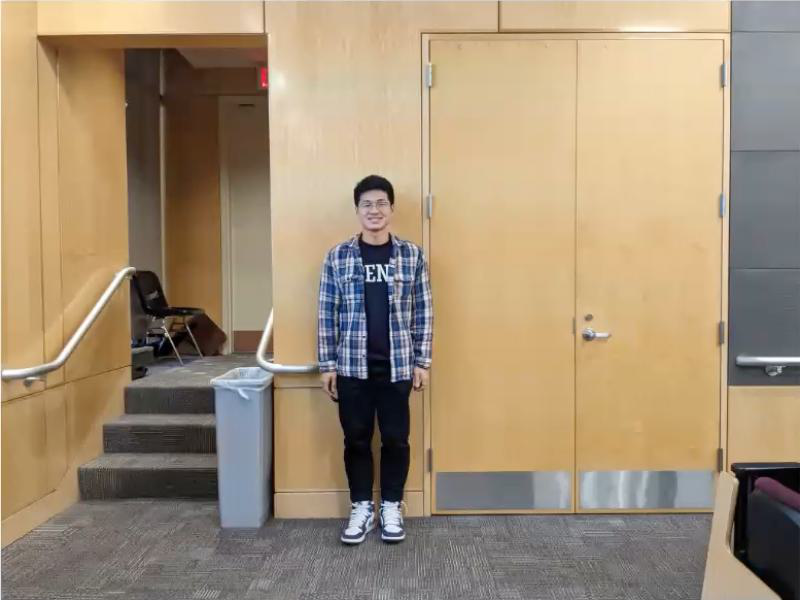

In [5]:
from PIL import Image
from IPython.display import display
img = Image.open('Images/group_1.jpg')
display(img)


In [7]:
import cv2
import numpy as np

def findHomographyOpticalFlow(img1, img2):
    """
    Find homography between image 1 and image 2 using optical flow for point tracking.

    :param img1: First input image.
    :param img2: Second input image.
    :return: Homography matrix as a 3x3 numpy array.
    """
    # Ensure the images are the same size
    if img1.shape[:2] != img2.shape[:2]:
        img1 = cv2.resize(img1, (img2.shape[1], img2.shape[0]))

    # Convert images to grayscale for optical flow calculation
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Detect Shi-Tomasi corners in img1
    corners = cv2.goodFeaturesToTrack(gray1, maxCorners=300, qualityLevel=0.01, minDistance=30, blockSize=3)

    # Calculate optical flow from img1 to img2 for corners
    corners_new, status, err = cv2.calcOpticalFlowPyrLK(gray1, gray2, corners, None)

    # Select good points
    good_old = corners[status == 1]
    good_new = corners_new[status == 1]

    # Find homography using RANSAC
    H, mask = cv2.findHomography(good_old, good_new, cv2.RANSAC, 5.0)
    return H

# Load images
img1 = cv2.imread('Images/group_1.jpg')  
img2 = cv2.imread('Images/group_2.jpg') 

# Estimate homography
H = findHomographyOpticalFlow(img1, img2)
if H is not None:
    print("Homography matrix:\n", H)
else:
    print("Homography could not be found.")

Homography matrix:
 [[ 9.93348566e-01  1.28427347e-03 -2.63318885e+00]
 [-2.60062108e-03  9.99695537e-01  1.16561058e+00]
 [ 1.96575056e-07 -5.91237293e-07  1.00000000e+00]]


In [9]:
from matplotlib import pyplot as plt
# plt.imshow(img1)
image_bgr = cv2.imread('Images/group_1.jpg')
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

In [10]:
# Assuming H is not None
height, width = img2.shape[:2]
warped_image = cv2.warpPerspective(img1, H, (width, height))

In [12]:
import cv2

# Reading the Image
image = cv2.imread('Images/group_1.jpg')

# initialize the HOG descriptor
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# detect humans in input image
(humans, _) = hog.detectMultiScale(image, winStride=(10, 10),
                                   padding=(32, 32), scale=1.1)

# Initialize an empty list to store bounding box coordinates
bounding_boxes = []

# loop over all detected humans
for (x, y, w, h) in humans:
    pad_w, pad_h = int(0.15 * w), int(0.01 * h)
    # Store the bounding box coordinates
    bounding_box = (x + pad_w, y + pad_h, x + w - pad_w, y + h - pad_h)
    bounding_boxes.append(bounding_box)
    cv2.rectangle(image, (bounding_box[0], bounding_box[1]), (bounding_box[2], bounding_box[3]), (0, 255, 0), 2)

# Print the bounding boxes
print("Bounding boxes:", bounding_boxes)


Bounding boxes: [(296, 145, 461, 596)]


In [17]:
import cv2
import numpy as np

# Assuming you already have your homography matrix H from findHomographyOpticalFlow
# and your source image img1 and destination image img2

def warpImage(img1, img2, H):
    """
    Warp img1 onto img2 plane using the homography matrix H

    :param img1: Source image to be warped.
    :param img2: Destination image onto which img1 will be warped.
    :param H: Homography matrix.
    :return: Warped version of img1.
    """
    # Get the dimensions of img2
    height, width, channels = img2.shape
    
    # Warp source image to destination based on homography
    warped_image = cv2.warpPerspective(img1, H, (width, height))
    
    return warped_image

# Load images
img1 = cv2.imread('Images/group_1.jpg')
img2 = cv2.imread('Images/group_2.jpg')

H = findHomographyOpticalFlow(img1, img2)

warped_img1 = warpImage(img1, img2, H)
warped_img1 = cv2.cvtColor(warped_img1, cv2.COLOR_BGR2RGB)

In [31]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    # Ensure that 'box' has the expected number of elements
    if len(box) >= 4:
        x0, y0 = box[0], box[1]
        w, h = box[2] - box[0], box[3] - box[1]
        ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))
    

In [35]:
input_box

array([[296, 145, 461, 596]])

In [34]:
input_box =  np.array(bounding_boxes)

from segment_anything import sam_model_registry, SamPredictor
sam = sam_model_registry["vit_h"](checkpoint="sam_ckpt/sam_vit_h_4b8939.pth")

predictor = SamPredictor(sam)

predictor.set_image(warped_img1)

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

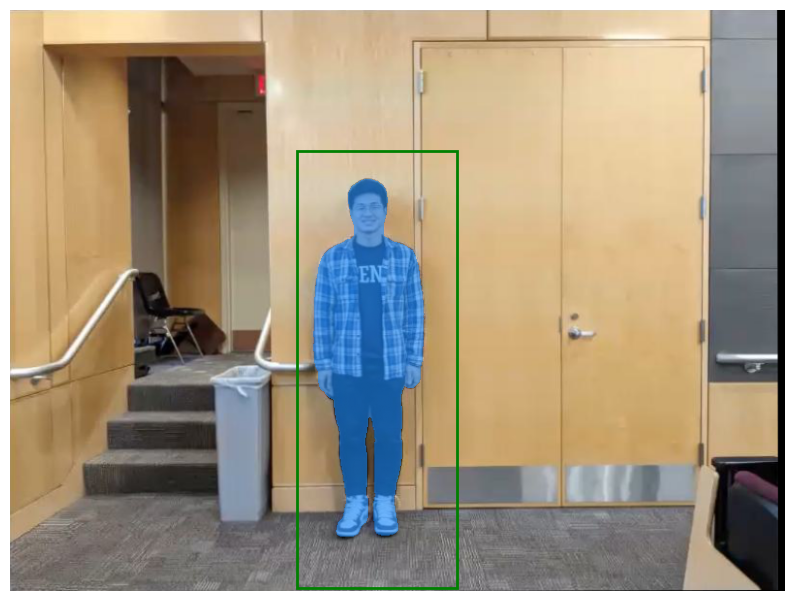

In [33]:
plt.figure(figsize=(10, 10))
plt.imshow(warped_img1)
show_mask(masks[0], plt.gca())
show_box(input_box[0], plt.gca())
plt.axis('off')
plt.show()

In [ ]:
# # Ensure masks are binary and of type uint8
# masks = masks.astype(np.uint8)
# masks[masks > 0] = 255

# if warped_img1 is None:
#     raise ValueError("Failed to load 'warped_img1'. Check the file path and ensure the image is not corrupted.")
# if img2 is None:
#     raise ValueError("Failed to load 'image2'. Check the file path and ensure the image is not corrupted.")

# # Ensure that the predictor returns a mask and not None
# if masks is None:
#     raise ValueError("The predictor did not return any mask. Check the predictor's input and settings.")


# # Apply the masks to the detected humans and add them to img2
# for i, box in enumerate(bounding_boxes):
#     x, y, w, h = box
#     # Ensure that the mask is binary and of type uint8
#     mask = masks[i].astype(np.uint8)
#     mask[mask != 0] = 255

#     # Resize mask to match the size of the bounding box
#     mask_resized = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)

#     # Extract the region of interest using the resized mask
#     # Make sure to resize or crop warped_img1 if it's not the same size as img2
#     human = cv2.bitwise_and(warped_img1[y:y+h, x:x+w], warped_img1[y:y+h, x:x+w], mask=mask_resized)
    
#     # Create an inverse mask for the ROI in img2
#     mask_inv = cv2.bitwise_not(mask_resized)
#     roi = img2[y:y+h, x:x+w]
#     roi_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

#     # Add the human to the ROI in img2
#     dst = cv2.add(roi_bg, human)
#     img2[y:y+h, x:x+w] = dst

# # Display the updated img2
# cv2.imshow('Image with Humans Added', img2)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


error: OpenCV(4.6.0) /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_d9lyif19nl/croot/opencv-suite_1676472756314/work/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'


In [ ]:
import numpy as np
import cv2
from segment_anything import sam_model_registry, SamPredictor

# Load the original image
warped_img1 = cv2.imread('1.jpg')
if warped_img1 is None:
    raise ValueError("Failed to load warped_img1")

# Initialize the SAM model
sam = sam_model_registry["vit_h"](checkpoint="/Users/kathy/Desktop/sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)

# Segment the image
input_box = np.array(bounding_boxes)  # Replace with your bounding boxes
predictor.set_image(warped_img1)
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False
)

# Extract the segmented part
segmented_part = np.where(masks[0, :, :, None], warped_img1, 0)

# Load the target image
img2 = cv2.imread('2.jpg')
if img2 is None:
    raise ValueError("Failed to load img2")

# Define the position to place the segmented part on img2
x, y = 100, 100  # Replace with your desired coordinates

# Original dimensions of the segmented part
height, width = segmented_part.shape[:2]

# Check if the segmented part fits within img2, if not, adjust x, y
if x + width > img2.shape[1] or y + height > img2.shape[0]:
    # Adjust x, y to fit the segmented part in img2
    x = max(0, img2.shape[1] - width)
    y = max(0, img2.shape[0] - height)

# Overlay the segmented part onto img2
img2[y:y+height, x:x+width] = np.where(segmented_part > 0, segmented_part, img2[y:y+height, x:x+width])

# Save or display the result
cv2.imwrite('/Users/kathy/Desktop/result.jpg', img2)
# cv2.imshow('Result', img2)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [36]:
masks = np.load('tmp/mask.npy')

In [44]:
masks = masks.astype(np.uint8)
masks

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

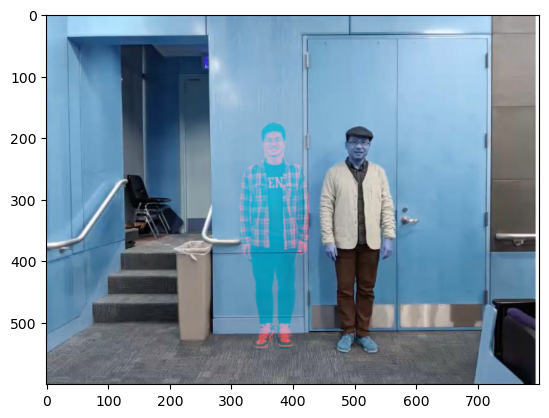

In [60]:
new_image = img2.copy()
new_image[:,:,0][np.where(masks)] = (warped_img1[:,:,0][np.where(masks)]).flatten()
new_image[:,:,1][np.where(masks)] = (warped_img1[:,:,1][np.where(masks)]).flatten()
new_image[:,:,2][np.where(masks)] = (warped_img1[:,:,2][np.where(masks)]).flatten()
# new_image[:,:,1] = masks * warped_img1[:,:,1]
# new_image[:,:,2] = masks * warped_img1[:,:,2]
new_image.reshape(600, 800, 3)
plt.imshow(new_image)